# Examining Distribution of Time Adverbials

In [1]:
from scripts.imports import *
out = Exporter(
    paths['outdir'], 
    'taxonomy'
)

# Distribution

For a set of clauses within a single book, 1–N, create clusters of clauses, where cluster = a 50 clause stretch. If a book ends without an even 50 clauses, keep the uneven cluster as either its own cluster (if N-clauses > 30) or add it to last cluster in the book.

We will now iterate through the clusters and tally the number of time adverbials contained within each one. We track along the way the starting points for each new book in the corpus. Those are recorded so they can be plotted. The plot is presented further below as a strip-plot.


# TODO: redo with built-in clause clusters

In [7]:
# build strip plot data

stripdata = {
    'location': [],
    'duration': []
}

covered_nodes = set()
bookboundaries = {}

# iterate through clauses and gather book data
this_book = None
for i, seg in enumerate(clause_segments):
    
    for cl in seg:
        book, chapter, verse = T.sectionFromNode(cl)
        this_book = book_map.get(book, book)
        
        # skip un-covered clauses
        if cl not in df.index:
            continue
            
        # skip TAs without qualities
        qual = df.loc[cl]['quality']
        if not qual or qual not in {'location', 'duration'}:
            continue
            
        # decide which to put it in    
        stripdata[qual].append(i+1)

        # add book boundaries for plotting
        if this_book not in bookboundaries: 
            bookboundaries[this_book] = i+1

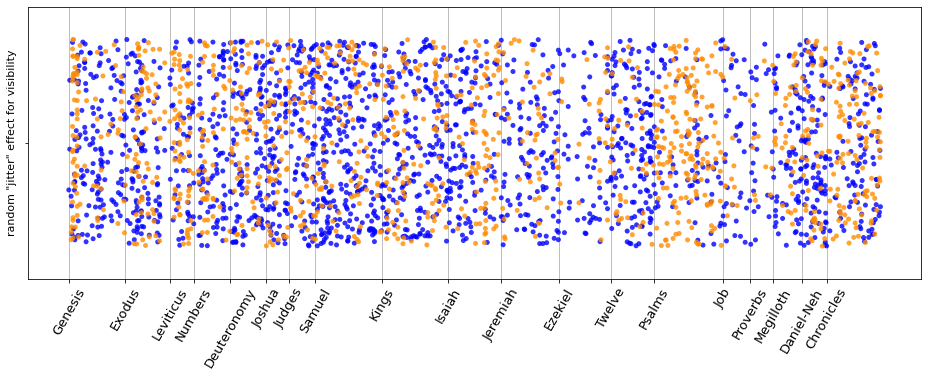

In [39]:
strip_title = 'Distribution of time adverbials by segments of ~50 clauses across Hebrew Bible'

# plot the durative and locatives
plt.figure(figsize=(16, 5))
sns.stripplot(x=stripdata['location'], color='blue', jitter=0.38, alpha=0.8)
sns.stripplot(x=stripdata['duration'], color='darkorange', jitter=0.38, alpha=0.8)
plt.xticks(ticks=list(bookboundaries.values()), labels=list(bookboundaries.keys()), rotation=60, size=13)
plt.ylabel('random "jitter" effect for visibility', size=11)
plt.grid(axis='x')
out.plot('dur_loc_stripplot')

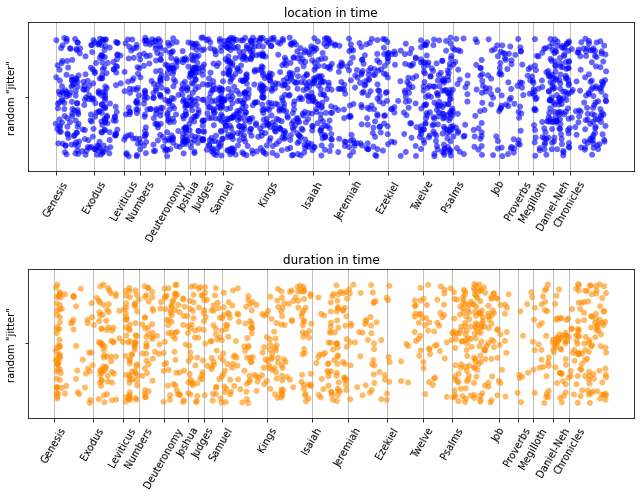

In [91]:
# plot the durative and locatives
fig, axs = plt.subplots(2, 1, figsize=(9, 7))
axs = axs.ravel()
colors = ['blue', 'darkorange']

for i, qual in enumerate(stripdata):
    ax = axs[i]
    sns.stripplot(
        x=stripdata[qual],
        ax=ax,
        color=colors[i], 
        jitter=0.4, 
        s=6, 
        alpha=.60, 
    )
    ax.set_xticks(list(bookboundaries.values()))
    ax.set_xticklabels(list(bookboundaries.keys()), rotation=60)
    ax.set_ylabel('random "jitter"')
    ax.grid(True, axis='x')
    ax.set_title(qual+' in time')

plt.tight_layout()
    
out.plot('dur_loc_separate_stripplot')

## Count by book

In [10]:
book_ct = pd.pivot_table(
    df,
    index=['booksuper'],
    columns=['quality'],
    aggfunc='size',
    fill_value=0,
)

book_ct

quality,duration,iteration,location,sequence
booksuper,,,,
Chronicles,111,17,111,23
Daniel,16,0,27,3
Deuteronomy,62,2,113,5
Exodus,69,11,110,13
Ezekiel,27,8,63,6
Ezra-Neh,32,4,67,22
Genesis,80,1,142,37
Isaiah,78,7,114,4
Jeremiah,46,3,118,12


## Measure of Distribution

## Distribution by Genre

In [11]:
genre_ct = pd.pivot_table(
    df,
    index=['genre', 'domain'],
    columns=['quality'],
    aggfunc='size',
    fill_value=0,
)

genre_ct

quality             duration  iteration  location  sequence
genre       domain                                         
instruction ?              1          0         3         0
            D              5          0         4         0
            N              0          1        14         2
            Q            133         19       108        20
list        ?              4          3        11         5
            D              0          1         0         0
            N             29          4         5        17
            Q              1          0         1         0
poetry      ?             13          0         9         1
            D              1          0         4         0
            N              0          0         1         0
            Q            205         18       159        11
prophetic   ?              0          1        47         3
            D              4          2        18         1
            N              4          1        39         4
            Q            165         12       296        19
prose       ?             39          0        53         7
            D             21          4        16         6
            N            293         18       456       109
            Q            243         20       703        38

In [12]:
# prune down to main genres
genre_ct2 = genre_ct.loc[idx[['prose', 'prophetic', 'poetry'], ['N', 'Q']], :]
genre_ct2 = genre_ct2.drop(index=[('poetry', 'N'), ('prophetic', 'N')])
genre_ct2

quality           duration  iteration  location  sequence
genre     domain                                         
prose     N            293         18       456       109
          Q            243         20       703        38
prophetic Q            165         12       296        19
poetry    Q            205         18       159        11

In [13]:
genre_pr = genre_ct2.div(genre_ct2.sum(1), 0)

# reorder
genre_pr = genre_pr[['location', 'duration', 'sequence', 'iteration']]
genre_pr

quality           location  duration  sequence  iteration
genre     domain                                         
prose     N       0.520548  0.334475  0.124429   0.020548
          Q       0.700199  0.242032  0.037849   0.019920
prophetic Q       0.601626  0.335366  0.038618   0.024390
poetry    Q       0.404580  0.521628  0.027990   0.045802

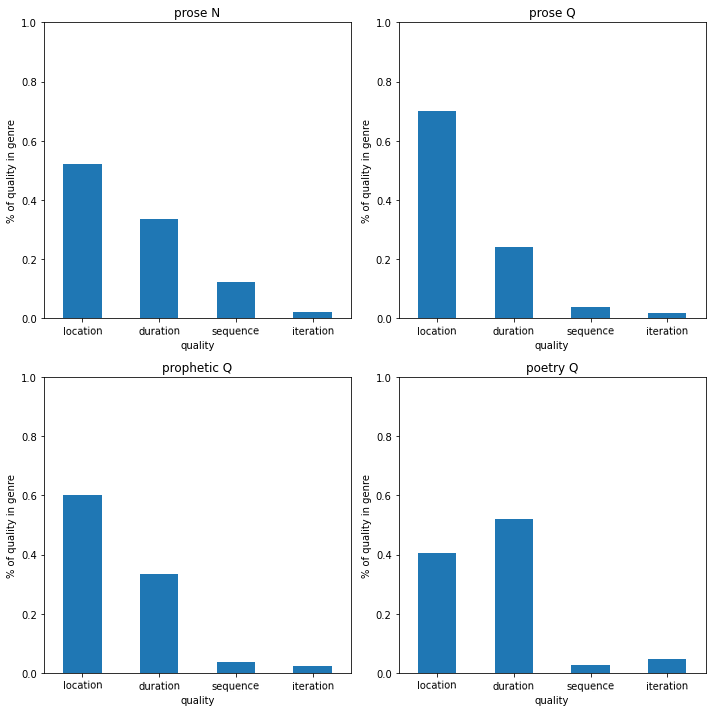

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()

for genre, ax in zip(genre_pr.index, axs):
    data = genre_pr.loc[genre]
    data.plot(kind='bar', ax=ax)
    ax.set_title(' '.join(genre))
    ax.set_ylim((0, 1))
    ax.set_ylabel('% of quality in genre')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0.9)
    
fig.tight_layout()

out.plot('percent_quals_bygenre')

### ΔP tests for genre

In [15]:
genre_dp = sig.apply_deltaP(genre_ct2, 0, 1)
genre_dp2 = sig.apply_deltaP(genre_ct2.T, 0, 1)

genre_dp

quality           duration  iteration  location  sequence
genre     domain                                         
prose     N       0.009965  -0.005921 -0.092475  0.088431
          Q      -0.134459  -0.007337  0.182879 -0.041084
prophetic Q       0.009365  -0.000247  0.021776 -0.030894
poetry    Q       0.226097   0.024722 -0.208826 -0.041993

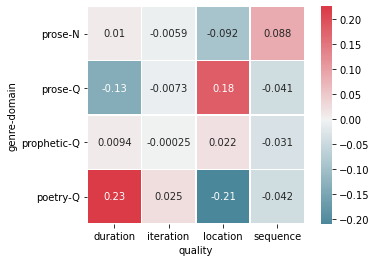

In [16]:
heatmap(genre_dp, annot=True)
out.plot('genreXquality_heatmap')

In [17]:
# the other way around
genre_dp2

genre         prose           prophetic    poetry
domain            N         Q         Q         Q
quality                                          
duration   0.009790 -0.141148  0.006218  0.125140
iteration -0.053425 -0.070732 -0.001505  0.125663
location  -0.082372  0.174052  0.013109 -0.104788
sequence   0.319451 -0.158572 -0.075422 -0.085457

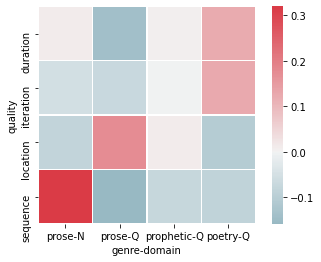

In [18]:
heatmap(genre_dp2)